# Linear Regression

## Agenda

1. Introducing the bikeshare dataset
    - Reading in the data
    - Visualizing the data
2. Linear regression basics
    - Form of linear regression
    - Building a linear regression model
    - Using the model for prediction
    - Does the scale of the features matter?
3. Working with multiple features
    - Visualizing the data (part 2)
    - Adding more features to the model
4. Choosing between models
    - Feature selection
    - Evaluation metrics for regression problems
    - Comparing models with train/test split and RMSE
    - Comparing testing RMSE with null RMSE
5. Creating features
    - Handling categorical features
    - Feature engineering
6. Comparing linear regression with other models

## Reading in the data

We'll be working with a dataset from Capital Bikeshare that was used in a Kaggle competition ([data dictionary](https://www.kaggle.com/c/bike-sharing-demand/data)).

In [1]:
# read the data and set the datetime as the index
%matplotlib inline
import pandas as pd

path= '../data/'
url = path + 'bikeshare.csv'  #path + 'bikeshare.csv'
bikes = pd.read_csv(url, index_col='datetime', parse_dates=True)

In [2]:
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
bikes.dtypes


season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

In [4]:
#bikes.dtypes
bikes.index

DatetimeIndex(['2011-01-01 00:00:00', '2011-01-01 01:00:00',
               '2011-01-01 02:00:00', '2011-01-01 03:00:00',
               '2011-01-01 04:00:00', '2011-01-01 05:00:00',
               '2011-01-01 06:00:00', '2011-01-01 07:00:00',
               '2011-01-01 08:00:00', '2011-01-01 09:00:00',
               ...
               '2012-12-19 14:00:00', '2012-12-19 15:00:00',
               '2012-12-19 16:00:00', '2012-12-19 17:00:00',
               '2012-12-19 18:00:00', '2012-12-19 19:00:00',
               '2012-12-19 20:00:00', '2012-12-19 21:00:00',
               '2012-12-19 22:00:00', '2012-12-19 23:00:00'],
              dtype='datetime64[ns]', name=u'datetime', length=10886, freq=None)

In [5]:
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


**Questions:**

- What does each observation represent? hour time frame
- What is the response variable (as defined by Kaggle)? count
- How many features are there? 11

In [6]:
# "count" is a method, so it's best to name that column something else
bikes.rename(columns={'count':'total'}, inplace=True)
bikes.columns

Index([u'season', u'holiday', u'workingday', u'weather', u'temp', u'atemp',
       u'humidity', u'windspeed', u'casual', u'registered', u'total'],
      dtype='object')

## Visualizing the data

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

In [8]:
len(bikes)

10886

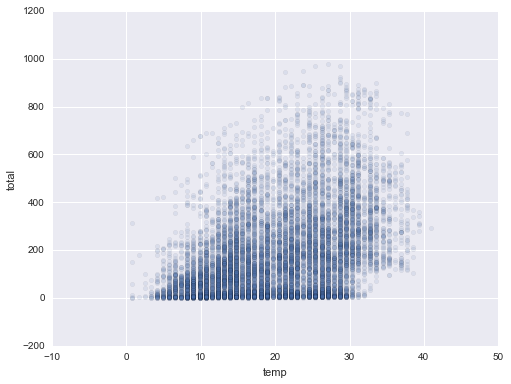

In [9]:
# Pandas scatter plot
bikes.plot(kind='scatter', x='temp', y='total', alpha=0.1)

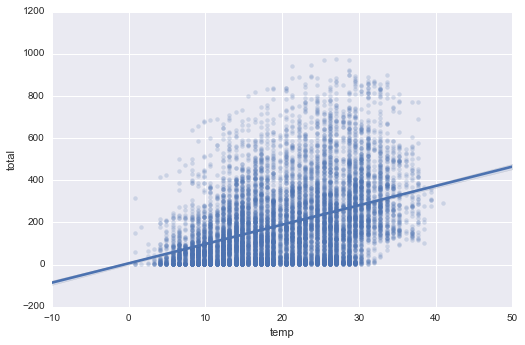

In [10]:
# Seaborn scatter plot with regression line
sns.lmplot(x='temp', y='total', data=bikes, aspect=1.5, scatter_kws={'alpha':0.2})

## Form of linear regression

$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n$

- $y$ is the response
- $\beta_0$ is the intercept
- $\beta_1$ is the coefficient for $x_1$ (the first feature)
- $\beta_n$ is the coefficient for $x_n$ (the nth feature)

The $\beta$ values are called the **model coefficients**:

- These values are estimated (or "learned") during the model fitting process using the **least squares criterion**.
- Specifically, we find the line (mathematically) which minimizes the **sum of squared residuals** (or "sum of squared errors").
- And once we've learned these coefficients, we can use the model to predict the response.

![Estimating coefficients](images/estimating_coefficients.png)

In the diagram above:

- The black dots are the **observed values** of x and y.
- The blue line is our **least squares line**.
- The red lines are the **residuals**, which are the vertical distances between the observed values and the least squares line.

## Building a simple linear regression model (one feature)

For our first task we decide to create a model which will predict the number of rentals based on the temperature.

In [11]:
# create X and y
feature_cols = ['temp']
X = bikes[feature_cols]
y = bikes.total
X.shape

(10886, 1)

In [12]:
type(X)

pandas.core.frame.DataFrame

In [13]:
y.shape

(10886L,)

In [14]:
type(y)

pandas.core.series.Series

In [15]:
# import, instantiate, fit
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [16]:
# print the coefficients
print linreg.intercept_
print linreg.coef_

6.04621295962
[ 9.17054048]


Interpreting the **intercept** ($\beta_0$):

- It is the value of $y$ when $x$=0.
- Thus, it is the estimated number of rentals when the temperature is 0 degrees Celsius.
- **Note:** It does not always make sense to interpret the intercept. (Why?)

Interpreting the **"temp" coefficient** ($\beta_1$):

- It is the change in $y$ divided by change in $x$, or the "slope".
- Thus, a temperature increase of 1 degree Celsius is **associated with** a rental increase of 9.17 bikes.
- This is not a statement of causation.
- $\beta_1$ would be **negative** if an increase in temperature was associated with a **decrease** in rentals.

## Using the model for prediction

How many bike rentals would we predict if the temperature was 25 degrees Celsius?

In [17]:
# manually calculate the prediction
linreg.intercept_ + linreg.coef_*21

array([ 198.62756307])

In [18]:
# use the predict method
linreg.predict(21)

array([ 198.62756307])

## Does the scale of the features matter?

Let's say that temperature was measured in Fahrenheit, rather than Celsius. How would that affect the model?

In [19]:
# create a new column for Fahrenheit temperature
bikes['temp_F'] = bikes.temp * 1.8 + 32
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,temp_F
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,49.712
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,48.236
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,48.236
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,49.712
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,49.712


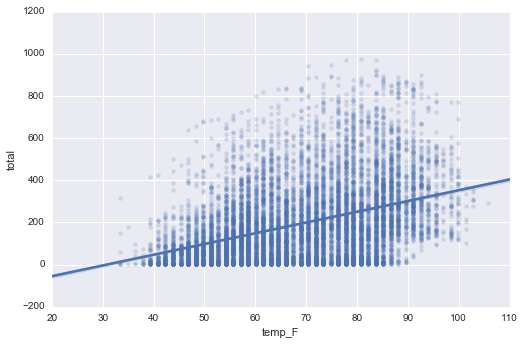

In [20]:
# Seaborn scatter plot with regression line
sns.lmplot(x='temp_F', y='total', data=bikes, aspect=1.5, scatter_kws={'alpha':0.2})

In [21]:
# create X and y
feature_cols = ['temp_F']
X = bikes[feature_cols]
y = bikes.total

# instantiate and fit
linreg = LinearRegression()
linreg.fit(X, y)

# print the coefficients
print linreg.intercept_
print linreg.coef_

-156.985617821
[ 5.09474471]


In [22]:
# convert 25 degrees Celsius to Fahrenheit
21 * 1.8 + 32

69.80000000000001

In [23]:
# predict rentals for 77 degrees Fahrenheit
linreg.predict(69.80000000000001)

array([ 198.62756307])

**Conclusion:** The scale of the features is **irrelevant** for linear regression models. When changing the scale, we simply change our **interpretation** of the coefficients.

In [24]:
# remove the temp_F column
bikes.drop('temp_F', axis=1, inplace=True)

In [25]:
bikes.head(10)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1
2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2
2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3
2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,7,8


## Visualizing the data (part 2)

In [26]:
# explore more features
feature_cols = ['temp', 'season', 'weather', 'humidity']

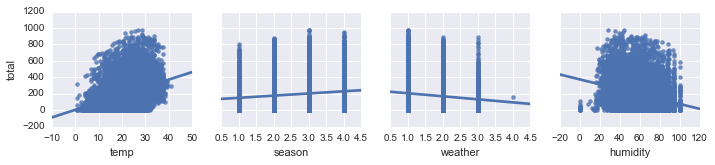

In [27]:
# multiple scatter plots in Seaborn
sns.pairplot(bikes, x_vars=feature_cols, y_vars='total', kind='reg')

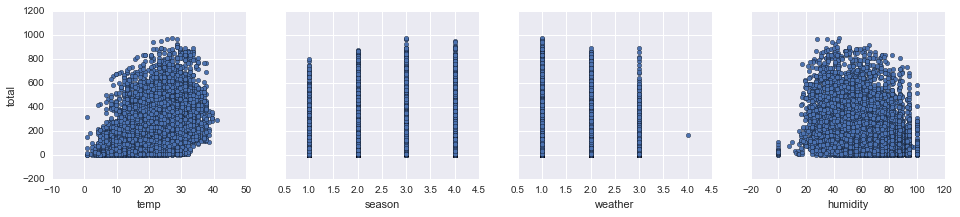

In [28]:
# multiple scatter plots in matplotlib
fig, axs = plt.subplots(1, len(feature_cols), sharey=True)
for index, feature in enumerate(feature_cols):
    bikes.plot(kind='scatter', x=feature, y='total', ax=axs[index], figsize=(16, 3))

Are you seeing anything that you did not expect?

In [29]:
# cross-tabulation of season and month
pd.crosstab(bikes.season, bikes.index.month)

col_0,1,2,3,4,5,6,7,8,9,10,11,12
season,,,,,,,,,,,,
1,884,901,901,0,0,0,0,0,0,0,0,0
2,0,0,0,909,912,912,0,0,0,0,0,0
3,0,0,0,0,0,0,912,912,909,0,0,0
4,0,0,0,0,0,0,0,0,0,911,911,912


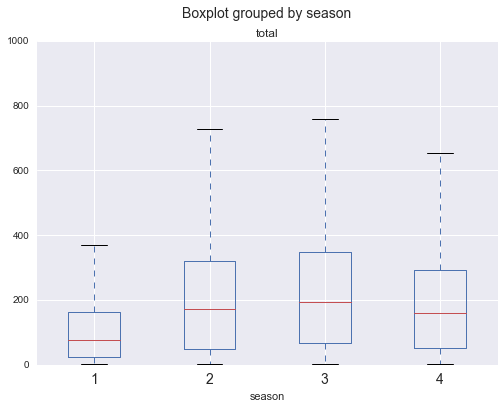

In [30]:
# box plot of rentals, grouped by season
bikes.boxplot(column='total', by='season')

Notably:

- A line can't capture a non-linear relationship.
- There are more rentals in winter than in spring (?)

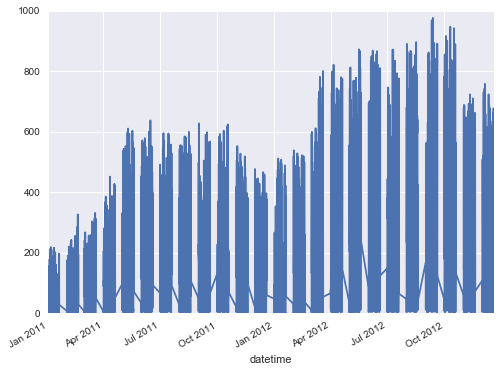

In [31]:
# line plot of rentals
bikes.total.plot()

What does this tell us?

There are more rentals in the winter than the spring, but only because the system is experiencing **overall growth** and the winter months happen to come after the spring months.

In [32]:
# correlation matrix (ranges from 1 to -1)
bikes.corr()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.096758,0.164011,0.163439
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,0.043799,-0.020956,-0.005393
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,-0.319111,0.119460,0.011594
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.135918,-0.109340,-0.128655
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.394454
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,0.389784
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,-0.317371
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,0.101369
casual,0.096758,0.043799,-0.319111,-0.135918,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,0.690414
registered,0.164011,-0.020956,0.119460,-0.109340,0.318571,0.314635,-0.265458,0.091052,0.497250,1.000000,0.970948


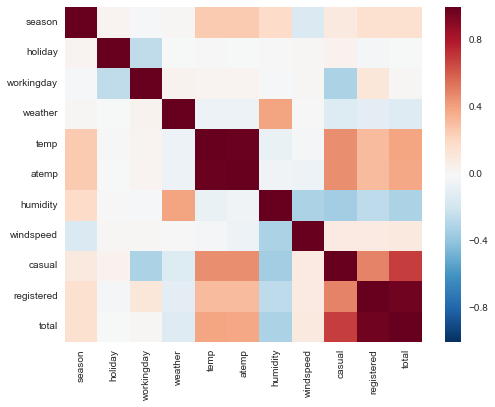

In [33]:
# visualize correlation matrix in Seaborn using a heatmap
sns.heatmap(bikes.corr())

What relationships do you notice?

## Adding more features to the model

In [34]:
# create a list of features
feature_cols = ['temp', 'season', 'weather', 'humidity']

In [35]:
# create X and y
X = bikes[feature_cols]
y = bikes.total

# instantiate and fit
linreg = LinearRegression()
linreg.fit(X, y)

# print the coefficients
print linreg.intercept_
print linreg.coef_

159.520687861
[  7.86482499  22.53875753   6.67030204  -3.11887338]


In [36]:
# pair the feature names with the coefficients
zip(feature_cols, linreg.coef_)

[('temp', 7.8648249924774403),
 ('season', 22.538757532466825),
 ('weather', 6.6703020359237941),
 ('humidity', -3.1188733823964938)]

Interpreting the coefficients:

- Holding all other features fixed, a 1 unit increase in **temperature** is associated with a **rental increase of 7.86 bikes**.
- Holding all other features fixed, a 1 unit increase in **season** is associated with a **rental increase of 22.5 bikes**.
- Holding all other features fixed, a 1 unit increase in **weather** is associated with a **rental increase of 6.67 bikes**.
- Holding all other features fixed, a 1 unit increase in **humidity** is associated with a **rental decrease of 3.12 bikes**.

Does anything look incorrect?

## Feature selection

How do we choose which features to include in the model? We're going to use **train/test split** (and eventually **cross-validation**).

Why not use of **p-values** or **R-squared** for feature selection?

- Linear models rely upon **a lot of assumptions** (such as the features being independent), and if those assumptions are violated, p-values and R-squared are less reliable. Train/test split relies on fewer assumptions.
- Features that are unrelated to the response can still have **significant p-values**.
- Adding features to your model that are unrelated to the response will always **increase the R-squared value**, and adjusted R-squared does not sufficiently account for this.
- p-values and R-squared are **proxies** for our goal of generalization, whereas train/test split and cross-validation attempt to **directly estimate** how well the model will generalize to out-of-sample data.

More generally:

- There are different methodologies that can be used for solving any given data science problem, and this course follows a **machine learning methodology**.
- This course focuses on **general purpose approaches** that can be applied to any model, rather than model-specific approaches.

## Evaluation metrics for regression problems

Evaluation metrics for classification problems, such as **accuracy**, are not useful for regression problems. We need evaluation metrics designed for comparing **continuous values**.

Here are three common evaluation metrics for regression problems:

**Mean Absolute Error** (MAE) is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Mean Squared Error** (MSE) is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

In [37]:
# example true and predicted response values
true = [10, 7, 5, 5]
pred = [8, 6, 5, 10]

In [38]:
# calculate these metrics by hand!
from sklearn import metrics
import numpy as np
print 'MAE:', metrics.mean_absolute_error(true, pred)
print 'MSE:', metrics.mean_squared_error(true, pred)
print 'RMSE:', np.sqrt(metrics.mean_squared_error(true, pred))

MAE: 2.0
MSE: 7.5
RMSE: 2.73861278753


Comparing these metrics:

- **MAE** is the easiest to understand, because it's the average error.
- **MSE** is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.
- **RMSE** is even more popular than MSE, because RMSE is interpretable in the "y" units.

All of these are **loss functions**, because we want to minimize them.

Here's an additional example, to demonstrate how MSE/RMSE punish larger errors:

In [39]:
# same true values as above
true = [10, 7, 5, 5]

# new set of predicted values
pred = [10, 7, 5, 13]

# MAE is the same as before
print 'MAE:', metrics.mean_absolute_error(true, pred)

# MSE and RMSE are larger than before
print 'MSE:', metrics.mean_squared_error(true, pred)
print 'RMSE:', np.sqrt(metrics.mean_squared_error(true, pred))

MAE: 2.0
MSE: 16.0
RMSE: 4.0


## Comparing models with train/test split and RMSE

In [40]:
from sklearn.cross_validation import train_test_split

# define a function that accepts a list of features and returns testing RMSE
def train_test_rmse(feature_cols):
    X = bikes[feature_cols]
    y = bikes.total
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_test)
    return np.sqrt(metrics.mean_squared_error(y_test, y_pred))

In [41]:
train_test_split(X, y, random_state=123)

[                      temp  season  weather  humidity
 datetime                                             
 2011-12-01 03:00:00  10.66       4        1        56
 2012-09-08 11:00:00  31.16       3        1        62
 2011-04-14 20:00:00  20.50       2        1        51
 2012-06-06 19:00:00  22.96       2        1        73
 2012-06-12 07:00:00  25.42       2        3        88
 2012-06-17 02:00:00  22.96       2        1        56
 2011-02-14 03:00:00  13.94       1        1        46
 2012-05-04 01:00:00  24.60       2        1        78
 2012-04-06 19:00:00  19.68       2        1        23
 2012-08-03 06:00:00  27.06       3        1        83
 2011-08-17 23:00:00  28.70       3        1        65
 2012-09-18 11:00:00  27.88       3        2        79
 2012-08-18 09:00:00  27.06       3        1        65
 2011-02-11 15:00:00  13.12       1        1        21
 2011-06-12 00:00:00  27.06       2        1        78
 2012-01-13 00:00:00  16.40       1        2        71
 2012-12-1

In [42]:
# compare different sets of features
print train_test_rmse(['temp', 'season', 'weather', 'humidity'])
print train_test_rmse(['temp', 'season', 'weather'])
print train_test_rmse(['temp', 'season', 'humidity'])

155.649459131
164.165399763
155.598189367


In [43]:
# using these as features is not allowed!
print train_test_rmse(['casual', 'registered'])

3.11749561277e-13


## Comparing testing RMSE with null RMSE

Null RMSE is the RMSE that could be achieved by **always predicting the mean response value**. It is a benchmark against which you may want to measure your regression model.

In [44]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

# create a NumPy array with the same shape as y_test
y_null = np.zeros_like(y_test, dtype=float)

# fill the array with the mean value of y_test
y_null.fill(y_test.mean())
y_null

array([ 192.26451139,  192.26451139,  192.26451139, ...,  192.26451139,
        192.26451139,  192.26451139])

In [45]:
# compute null RMSE
np.sqrt(metrics.mean_squared_error(y_test, y_null))

179.57906896465727

## Handling categorical features

scikit-learn expects all features to be numeric. So how do we include a categorical feature in our model?

- **Ordered categories:** transform them to sensible numeric values (example: small=1, medium=2, large=3)
- **Unordered categories:** use dummy encoding (0/1)

What are the categorical features in our dataset?

- **Ordered categories:** weather (already encoded with sensible numeric values)
- **Unordered categories:** season (needs dummy encoding), holiday (already dummy encoded), workingday (already dummy encoded)

For season, we can't simply leave the encoding as 1 = spring, 2 = summer, 3 = fall, and 4 = winter, because that would imply an **ordered relationship**. Instead, we create **multiple dummy variables:**

In [46]:
# create dummy variables
season_dummies = pd.get_dummies(bikes.season, prefix='season')

# print 5 random rows
season_dummies.sample(n=5, random_state=1)

,season_1,season_2,season_3,season_4
datetime,,,,
2011-09-05 11:00:00,0.0,0.0,1.0,0.0
2012-03-18 04:00:00,1.0,0.0,0.0,0.0
2012-10-14 17:00:00,0.0,0.0,0.0,1.0
2011-04-04 15:00:00,0.0,1.0,0.0,0.0
2012-12-11 02:00:00,0.0,0.0,0.0,1.0


However, we actually only need **three dummy variables (not four)**, and thus we'll drop the first dummy variable.

Why? Because three dummies captures all of the "information" about the season feature, and implicitly defines spring (season 1) as the **baseline level:**

In [47]:
# drop the first column
season_dummies.drop(season_dummies.columns[0], axis=1, inplace=True)

# print 5 random rows
season_dummies.sample(n=5, random_state=1)

,season_2,season_3,season_4
datetime,,,
2011-09-05 11:00:00,0.0,1.0,0.0
2012-03-18 04:00:00,0.0,0.0,0.0
2012-10-14 17:00:00,0.0,0.0,1.0
2011-04-04 15:00:00,1.0,0.0,0.0
2012-12-11 02:00:00,0.0,0.0,1.0


In general, if you have a categorical feature with **k possible values**, you create **k-1 dummy variables**.

If that's confusing, think about why we only need one dummy variable for holiday, not two dummy variables (holiday_yes and holiday_no).

In [48]:
# concatenate the original DataFrame and the dummy DataFrame (axis=0 means rows, axis=1 means columns)
bikes = pd.concat([bikes, season_dummies], axis=1)

# print 5 random rows
bikes.sample(n=5, random_state=1)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,season_2,season_3,season_4
datetime,,,,,,,,,,,,,,
2011-09-05 11:00:00,3,1,0,2,28.70,33.335,74,11.0014,101,207,308,0.0,1.0,0.0
2012-03-18 04:00:00,1,0,0,2,17.22,21.210,94,11.0014,6,8,14,0.0,0.0,0.0
2012-10-14 17:00:00,4,0,0,1,26.24,31.060,44,12.9980,193,346,539,0.0,0.0,1.0
2011-04-04 15:00:00,2,0,1,1,31.16,33.335,23,36.9974,47,96,143,1.0,0.0,0.0
2012-12-11 02:00:00,4,0,1,2,16.40,20.455,66,22.0028,0,1,1,0.0,0.0,1.0


In [49]:
# include dummy variables for season in the model
feature_cols = ['temp', 'season_2', 'season_3', 'season_4', 'humidity']
X = bikes[feature_cols]
y = bikes.total
linreg = LinearRegression()
linreg.fit(X, y)
zip(feature_cols, linreg.coef_)

[('temp', 11.186405863575766),
 ('season_2', -3.3905430997176023),
 ('season_3', -41.736860713170195),
 ('season_4', 64.415961468242529),
 ('humidity', -2.8194816362596473)]

How do we interpret the season coefficients? They are **measured against the baseline (spring)**:

- Holding all other features fixed, **summer** is associated with a **rental decrease of 3.39 bikes** compared to the spring.
- Holding all other features fixed, **fall** is associated with a **rental decrease of 41.7 bikes** compared to the spring.
- Holding all other features fixed, **winter** is associated with a **rental increase of 64.4 bikes** compared to the spring.

Would it matter if we changed which season was defined as the baseline?

- No, it would simply change our **interpretation** of the coefficients.

**Important:** Dummy encoding is relevant for all machine learning models, not just linear regression models.

In [50]:
# compare original season variable with dummy variables
print train_test_rmse(['temp', 'season', 'humidity'])
print train_test_rmse(['temp', 'season_2', 'season_3', 'season_4', 'humidity'])

155.598189367
154.333945936


## Feature engineering

See if you can create the following features:

- **hour:** as a single numeric feature (0 through 23)
- **hour:** as a categorical feature (use 23 dummy variables)
- **daytime:** as a single categorical feature (daytime=1 from 7am to 8pm, and daytime=0 otherwise)

Then, try using each of the three features (on its own) with `train_test_rmse` to see which one performs the best!

In [51]:
# hour as a numeric feature
bikes['hours'] = bikes.index.hour
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,season_2,season_3,season_4,hours
datetime,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0.0,0.0,0.0,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,0.0,0.0,0.0,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,0.0,0.0,0.0,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,0.0,0.0,0.0,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,0.0,0.0,0.0,4


In [52]:
# hour as a categorical feature 

# create dummy variables
hours_dummies = pd.get_dummies(bikes.hours, prefix='time')

# print 5 random rows
hours_dummies.sample(n=5, random_state=1)

,time_0,time_1,time_2,time_3,time_4,time_5,time_6,time_7,time_8,time_9,...,time_14,time_15,time_16,time_17,time_18,time_19,time_20,time_21,time_22,time_23
datetime,,,,,,,,,,,,,,,,,,,,,
2011-09-05 11:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-03-18 04:00:00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-10-14 17:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-04-04 15:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-12-11 02:00:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
#example of list comprehension in pandas

# daytime as a categorical feature 
# categotrical daytime 
bikes['daytime'] = [1 if x >= 7 and x <= 20 else 0 for x in bikes['hours']]

bikes.head(24)



,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,season_2,season_3,season_4,hours,daytime
datetime,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,0.0,0.0,0.0,0,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,0.0,0.0,0.0,1,0
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,0.0,0.0,0.0,2,0
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,0.0,0.0,0.0,3,0
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,0.0,0.0,0.0,4,0
2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1,0.0,0.0,0.0,5,0
2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2,0.0,0.0,0.0,6,0
2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3,0.0,0.0,0.0,7,1
2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,7,8,0.0,0.0,0.0,8,1


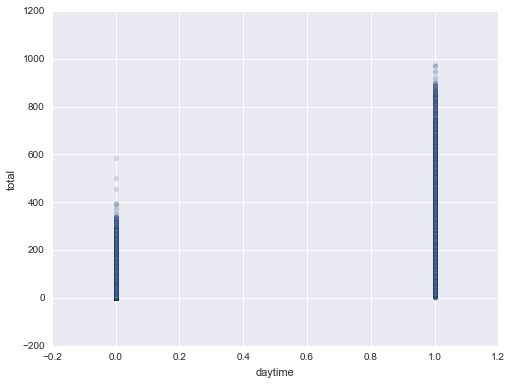

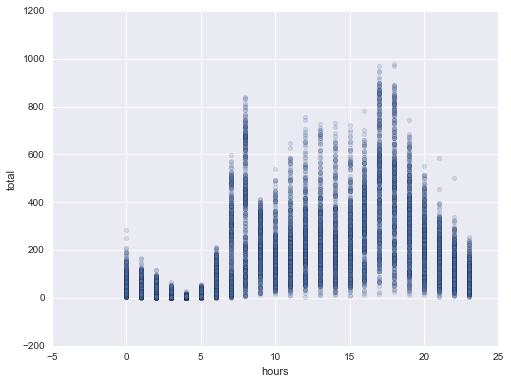

In [54]:
feature_cols =['temp', 'season_2', 'season_3', 'season_4', 'weather', 'humidity', 'daytime']
x = bikes[feature_cols]
y = bikes.total

x.shape

bikes.plot(kind='scatter', x='daytime', y='total', alpha=0.2)
bikes.plot(kind='scatter', x='hours', y='total', alpha=0.2)

In [55]:
feature_cols =['temp', 'season_2', 'season_3', 'season_4', 'weather', 'humidity', 'daytime']
x = bikes[feature_cols]
y = bikes.total
linreg = LinearRegression()
linreg.fit(x, y)
zip(feature_cols, linreg.coef_)

[('temp', 7.3193291131186369),
 ('season_2', 30.119777845014376),
 ('season_3', 8.015287902988856),
 ('season_4', 65.73897561274913),
 ('weather', -21.457090677168456),
 ('humidity', -1.1016446999402305),
 ('daytime', 186.95712276765943)]

In [56]:
print train_test_rmse(['temp', 'season', 'humidity'])
print train_test_rmse(['temp', 'season_2', 'season_3', 'season_4', 'humidity'])
print train_test_rmse(['temp', 'weather', 'daytime'])
print train_test_rmse(['season_2', 'season_3', 'season_4', 'temp', 'weather', 'daytime'])

print train_test_rmse(['season_2', 'season_3', 'season_4', 'temp', 'weather', 'daytime', 'humidity'])
print train_test_rmse(['daytime'])


155.598189367
154.333945936
132.84507125
131.169983148
129.952982988
144.891163602


## Comparing linear regression with other models

Advantages of linear regression:

- Simple to explain
- Highly interpretable
- Model training and prediction are fast
- No tuning is required (excluding regularization)
- Features don't need scaling
- Can perform well with a small number of observations
- Well-understood

Disadvantages of linear regression:

- Presumes a linear relationship between the features and the response
- Performance is (generally) not competitive with the best supervised learning methods due to high bias
- Can't automatically learn feature interactions